In [1]:
# Import local modules
import sys
import os
import glob

# Import third-party modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import iris
from xarray import DataArray

In [2]:
import dictionaries as dicts

from functions import *

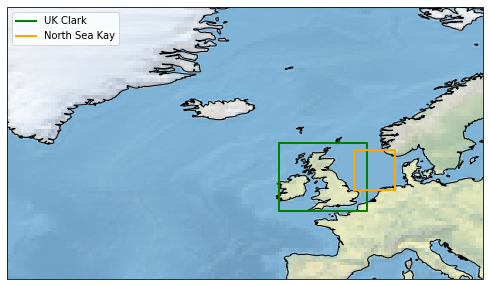

In [3]:
# First, we want to visualise th gridboxes which we might want to use
# The UK grid box or the north sea grid box

# Set up the projection
projection = ccrs.PlateCarree(central_longitude=0)

# Plot the differences between the two gridboxes
# Set up the figure
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=projection)

# # Include the stock image and coastlines
ax.stock_img()
ax.coastlines()

# Extract the lat and lon data for the UK box
lon1_uk, lon2_uk = dicts.uk_grid['lon1'], dicts.uk_grid['lon2']
lat1_uk, lat2_uk = dicts.uk_grid['lat1'], dicts.uk_grid['lat2']

# Extract the lat and lon data for the North Sea box
lon1_ns, lon2_ns = dicts.north_sea_kay['lon1'], dicts.north_sea_kay['lon2']
lat1_ns, lat2_ns = dicts.north_sea_kay['lat1'], dicts.north_sea_kay['lat2']

# Plot these boxes
ax.plot([lon1_uk, lon2_uk, lon2_uk, lon1_uk, lon1_uk],
        [lat1_uk, lat1_uk, lat2_uk, lat2_uk, lat1_uk],
        color='green', linewidth=2, transform=projection, label="UK Clark")

# Plot these boxes
ax.plot([lon1_ns, lon2_ns, lon2_ns, lon1_ns, lon1_ns],
        [lat1_ns, lat1_ns, lat2_ns, lat2_ns, lat1_ns],
        color='orange', linewidth=2, transform=projection, label="North Sea Kay")

# Zoom in on the region
ax.set_extent([-50, 20, 40, 80], crs=projection)

# Create a legend
ax.legend(loc = 'upper left')

# show the plot
plt.show()

In [4]:
# Set up the parameters for extraction
model_var = "sfcWind"
obs_var = "ws"
test_model = "HadGEM3-GC31-MM"
experiment = "dcppA-hindcast"

In [5]:
import importlib

importlib.reload(sys.modules['functions'])

from functions import load_model_data

In [6]:
# Set up the path to the data
data_path = "/gws/nopw/j04/canari/users/benhutch/20CRv3/test_10m_wind.nc"

# Load the data
long_obs = xr.open_dataset(data_path)

# Extract the obs variable
long_obs = long_obs[obs_var]

In [7]:
long_obs

<xarray.DataArray 'ws' (time: 2520, lat: 181, lon: 360)>
[164203200 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1806-01-01 1806-02-01 ... 2015-12-01
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
Attributes:
    standard_name:     eastward_wind
    long_name:         Monthly U-wind at 10m
    units:             m/s
    cell_methods:      time: mean (monthly from 3-hourly values)
    GRIB_name:         UGRD10m
    var_desc:          u-wind
    dataset:           NOAA/CIRES/DOE 20th Century Reanalysis version 3si-mo ...
    level_desc:        10 m
    statistic:         Ensemble Mean
    parent_stat:       Daily Values
    statistic_method:  Ensemble mean is calculated by averaging over all 80 e...
    GridType:          Cylindrical Equidistant Projection Grid
    datum:             wgs84
    actual_range:      [-15.989945  14.219341]

### Regridding ###

This will need to be regridded to compare with the model data, but for now we just want to look at the low wind years.

In [8]:
# Take the mean of the obs data for the UK region
obs_uk = long_obs.sel(lat=slice(lat1_uk, lat2_uk), 
                      lon=slice(lon1_uk, lon2_uk)).mean(dim=['lat', 'lon'])

# Extract the initial year
first_year = obs_uk.time.dt.year[0].values
last_year = obs_uk.time.dt.year[-1].values

In [9]:
print(first_year, last_year)
print(type(first_year))
print(type(last_year))

# Convert to integers
first_year = int(first_year)
last_year = int(last_year)

print(first_year, last_year)

# print the type of the first year
print(type(first_year))
print(type(last_year))

1806 2015
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
1806 2015
<class 'int'>
<class 'int'>


In [10]:
# Take the year means - set up the array for this first
years = np.arange(first_year, last_year+1)
n_months = 12

# Set the averaging period
avg_period = 1 # in years

# Set up the array for the year means
obs_uk_year = np.zeros([len(years), n_months])

# Loop over the years
for year in tqdm(years):
    # Extract the data for this year - December to November
    obs_uk_slice = obs_uk.sel(time=slice(f"{year}-12-01",
                                        f"{year+avg_period}-11-30"))
    
    # Extract the data
    obs_uk_year[year - first_year, :] = obs_uk_slice.values


# Print the shape of the obs data
print(obs_uk_year.shape)

100%|██████████| 210/210 [00:00<00:00, 848.74it/s]

(210, 12)


In [11]:
# Calculate the stats for the obs
obs_uk_stats = calculate_obs_stats(obs_data=obs_uk_year,
                                   start_year=1806,
                                   end_year=2015,
                                   avg_period=1,
                                   grid=dicts.uk_grid)

In [12]:
# Load the other obs data
obs_data_era5 = load_obs_data(obs_variable="si10",
                              regrid_obs_path="/home/users/benhutch/ERA5/surface_wind_ERA5_regrid_HadGEM.nc",
                              start_year=1960,
                              end_year=2022,
                              avg_period=1,
                              grid=dicts.uk_grid)

First time: 1960
Last time: 2021
Slicing over: 1960-12-01 1961-11-30
Number of months: 12
Shape of obs data: (62, 12)


Processing years:   0%|          | 0/62 [00:00<?, ?it/s]

Processing years: 100%|██████████| 62/62 [03:45<00:00,  3.64s/it]

Shape of obs data: (62, 12)


In [13]:
print(obs_data_era5[0].shape)

(62, 12)


In [14]:
# Calculate the stats for the obs
obs_era5_stats = calculate_obs_stats(obs_data=obs_data_era5[0],
                                     start_year=1960,
                                     end_year=2022,
                                     avg_period=1,
                                     grid=dicts.uk_grid)

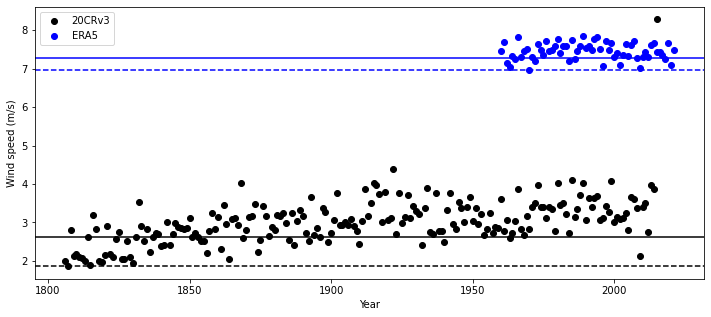

In [15]:
# NOTE: 20CRv3 needs to be regirdded to the same grid as the model data (and ERA5)
# NOTE: 20CRv3 is wind speed at the surface, not at 10m?
# Set up the figure
plt.figure(figsize=(12, 5))

# Plot the obs data
plt.scatter(years, obs_uk_year.mean(axis=1), label="20CRv3", color='black')

# Plot the ERA5 data
plt.scatter(obs_data_era5[1], obs_data_era5[0].mean(axis=1), label="ERA5", color='blue')

# Plot the 20th percentile
plt.axhline(obs_uk_stats['min_20'], color='black', linestyle='-')

# Plot the 20th percentile for ERA5
plt.axhline(obs_era5_stats['min_20'], color='blue', linestyle='-')

# plot the minimum
plt.axhline(obs_uk_stats['min'], color='black', linestyle='--')

# plot the minimum for ERA5
plt.axhline(obs_era5_stats['min'], color='blue', linestyle='--')

# Add a legend in the upper left corner
plt.legend(loc='upper left')

# Add the axis labels
plt.xlabel("Year")

# Add the y label
plt.ylabel("Wind speed (m/s)")

# Show the plot
plt.show()

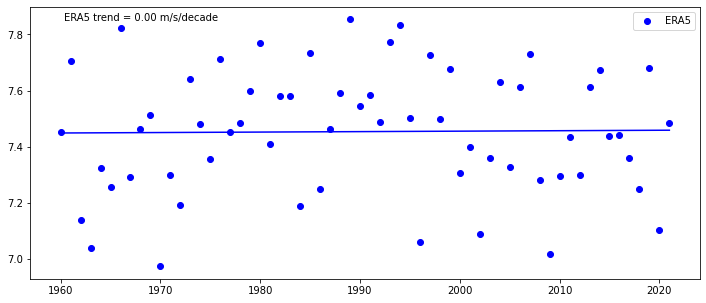

In [16]:
# Have a look at the trend in the ERA5 data
# Set up the figure
plt.figure(figsize=(12, 5))

# Plot the obs data
plt.scatter(obs_data_era5[1], obs_data_era5[0].mean(axis=1), label="ERA5", color='blue')

# Fit a linear trend to the data
m, c = np.polyfit(obs_data_era5[1], obs_data_era5[0].mean(axis=1), 1)

# Plot the trend line
plt.plot(obs_data_era5[1], m*obs_data_era5[1] + c, color='blue')

# Include a text box with the trend
plt.text(0.05, 0.95, f"ERA5 trend = {m*10:.2f} m/s/decade",
         transform=plt.gca().transAxes)

# Add a legend in the upper left corner
plt.legend(loc='upper right')

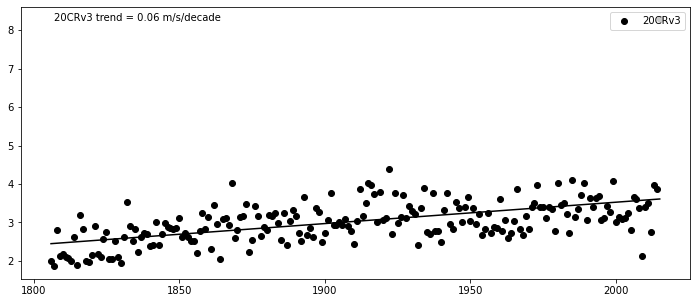

In [17]:
# Same as above but for 20CRv3
# Set up the figure
plt.figure(figsize=(12, 5))

# Plot the obs data
plt.scatter(years, obs_uk_year.mean(axis=1), label="20CRv3", color='black')

# Fit a linear trend to the data
m, c = np.polyfit(years, obs_uk_year.mean(axis=1), 1)

# Plot the trend line
plt.plot(years, m*years + c, color='black')

# Include a text box with the trend
plt.text(0.05, 0.95, f"20CRv3 trend = {m*10:.2f} m/s/decade",
         transform=plt.gca().transAxes)

# Add a legend in the upper left corner
plt.legend(loc='upper right')

In [18]:
# Load the model data
model_data = load_model_data(model_variable=model_var,
                             model=test_model,
                             experiment=experiment,
                                start_year=1960,
                                end_year=2018,
                                avg_period=1,
                                grid=dicts.uk_grid)

/gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/sfcWind/HadGEM3-GC31-MM/merged_files
Number of files: 590
First time: 1960-11-16 00:00:00
First year: 1960
Slicing over: 1960-12-01 1961-11-30
Number of months: 12
Shape of model data: (59, 10, 12)


Processing years: 100%|██████████| 59/59 [08:30<00:00,  8.65s/it]

Shape of model data: (59, 10, 12)


In [30]:
print(model_data.shape)

model_data_members = model_data

(59, 10)


(59, 10)


Text(0.05, 0.9, 'ERA5 trend = 0.00 m/s/decade\nHadGEM3-GC31-MM trend = -0.02 m/s/decade')

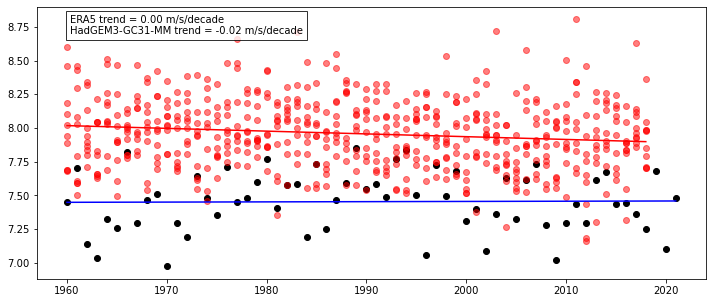

In [41]:
# Plot the model data and the trend alongside the obs data ERA5
# Set up the figure
plt.figure(figsize=(12, 5))

# Plot the obs data
plt.scatter(obs_data_era5[1], obs_data_era5[0].mean(axis=1), label="ERA5", color='black')

# Fit a linear trend to the data
m, c = np.polyfit(obs_data_era5[1], obs_data_era5[0].mean(axis=1), 1)

# Plot the trend line
plt.plot(obs_data_era5[1], m*obs_data_era5[1] + c, color='blue')

# print(np.shape(np.arange(1960, 2018 + 1)))
# print(np.shape(model_data.mean(axis=2)))

# # Process the model data
# model_data = model_data.mean(axis=2)

# Print the shape of the model data
print(np.shape(model_data))

years = np.arange(1960, 2018 + 1)

# Loop over the ensemble members
for i in range(model_data_members.shape[1]):
    # Plot the model data
    plt.scatter(np.arange(1960, 2018 + 1), model_data_members[:, i], color='red', alpha=0.5)

# # Plot the model data
# plt.scatter(np.arange(1960, 2018 + 1), model_data, label="HadGEM3-GC31-MM", color='red')

# Take the ensemble mean
model_data_mean = model_data_members.mean(axis=1)

# Fit a linear trend to the data
m_model, c_model = np.polyfit(np.arange(1960, 2018 + 1), model_data_mean, 1)

# Plot the trend line
plt.plot(np.arange(1960, 2018 + 1), m_model*np.arange(1960, 2018 + 1) + c_model, color='red')

# Include a text box with the trend
# Include a text box with the trend
plt.text(0.05, 0.90, f"ERA5 trend = {m*10:.2f} m/s/decade\nHadGEM3-GC31-MM trend = {m_model*10:.2f} m/s/decade",
         transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8))

In [ ]:
# Include a text box with the trend
plt.text(0.05, 0.95, f"ERA5 trend = {m*10:.2f} m/s/decade\nHadGEM3-GC31-MM trend = {m*10:.2f} m/s/decade",
         transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8))